## face thing first
i was trying to retrain this but it crashed midway, now these scripts won't work because i made changes

In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
import os
import tensorflow as tf
import tensorflow_addons as tfa
import PIL
import PIL.ImageOps
from tensorflow.keras.utils import plot_model

import itertools
import seaborn as sns

AUTOTUNE = tf.data.experimental.AUTOTUNE

from utils.config import Config
from utils.dataset_preprocessing import fix_images
import model
import dataset
import logging
from model import landmarks_model
from train.train_landmarks import train_landmarks
from tensorflow.keras.models import load_model
import dataset.landmarks_dataset as ld_dataset
import dataset.landmarks_faces_pretrain_dataset as faces_dataset
configuration = Config()

In [97]:
# reload the library
import importlib
import types
import os

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        importlib.reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)


reload_package(faces_dataset)

In [98]:
dataset = faces_dataset.landmark_pretrain_faces_dataset(configuration)
faces, faces_val = dataset.create_train_dataset()

WARNING - Missing permissions to create directory for caching!
WARNING - Missing permissions to create directory for caching!


(25, 512, 512, 1)


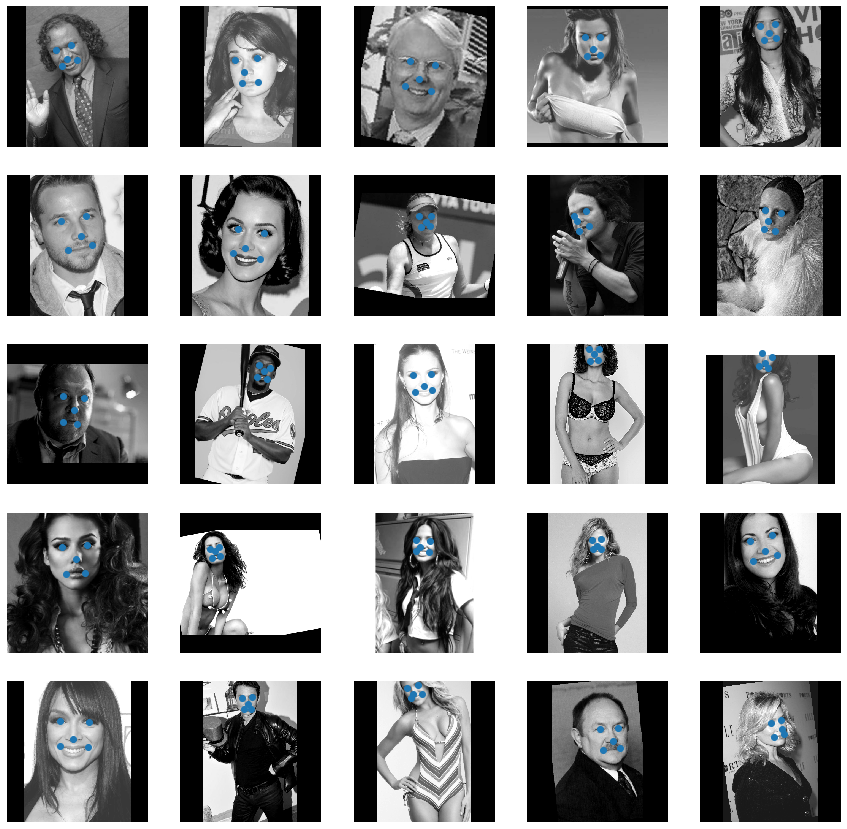

In [99]:
for a,b in faces.take(1):
    print(a.shape)
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8]],np.array(b[n])[[1,3,5,7,9]])
        plt.axis('off')


In [100]:
model = landmarks_model.resnet_landmarks_model(configuration,10)

In [101]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 1000)              25607528  
_________________________________________________________________
dense_4 (Dense)              (None, 256)               256256    
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 25,867,378
Trainable params: 25,821,426
Non-trainable params: 45,952
_________________________________________________________________


In [102]:
model.load_weights("weights/FACE_pretrain_resnet_model_250")

In [ ]:
# H = model.fit(faces, validation_data=faces_val,steps_per_epoch=2000,
#     epochs=30,validation_steps=10)

Train for 2000 steps, validate for 10 steps
Epoch 1/30
2000/2000 [==============================] - 447s 224ms/step - loss: 11054.7690 - mae: 66.8473 - val_loss: 740.2638 - val_mae: 18.6995
Epoch 2/30
2000/2000 [==============================] - 440s 220ms/step - loss: 436.9735 - mae: 14.6164 - val_loss: 373.1965 - val_mae: 13.2380
Epoch 3/30
2000/2000 [==============================] - 441s 221ms/step - loss: 370.2538 - mae: 13.3578 - val_loss: 974.7065 - val_mae: 21.1300
Epoch 4/30
2000/2000 [==============================] - 440s 220ms/step - loss: 331.1557 - mae: 12.6868 - val_loss: 137.8096 - val_mae: 7.9035
Epoch 5/30
2000/2000 [==============================] - 435s 217ms/step - loss: 320.5632 - mae: 12.5340 - val_loss: 1935.6387 - val_mae: 33.1626
Epoch 6/30
2000/2000 [==============================] - 434s 217ms/step - loss: 276.9817 - mae: 11.6659 - val_loss: 186.9396 - val_mae: 8.5790
Epoch 7/30
2000/2000 [==============================] - 433s 217ms/step - loss: 262.3592 - 

In [15]:
truths = [[],[],[]]
preds = [[],[],[]]  
for a,b in faces_val.take(50):
    h = model.predict(a)
    for i in range(3):
        truths[i].extend(list(itertools.chain(*np.array(b[i]).tolist())))
        preds[i].extend(list(itertools.chain(*np.array(h[i]).tolist())))

TypeError: 'float' object is not iterable

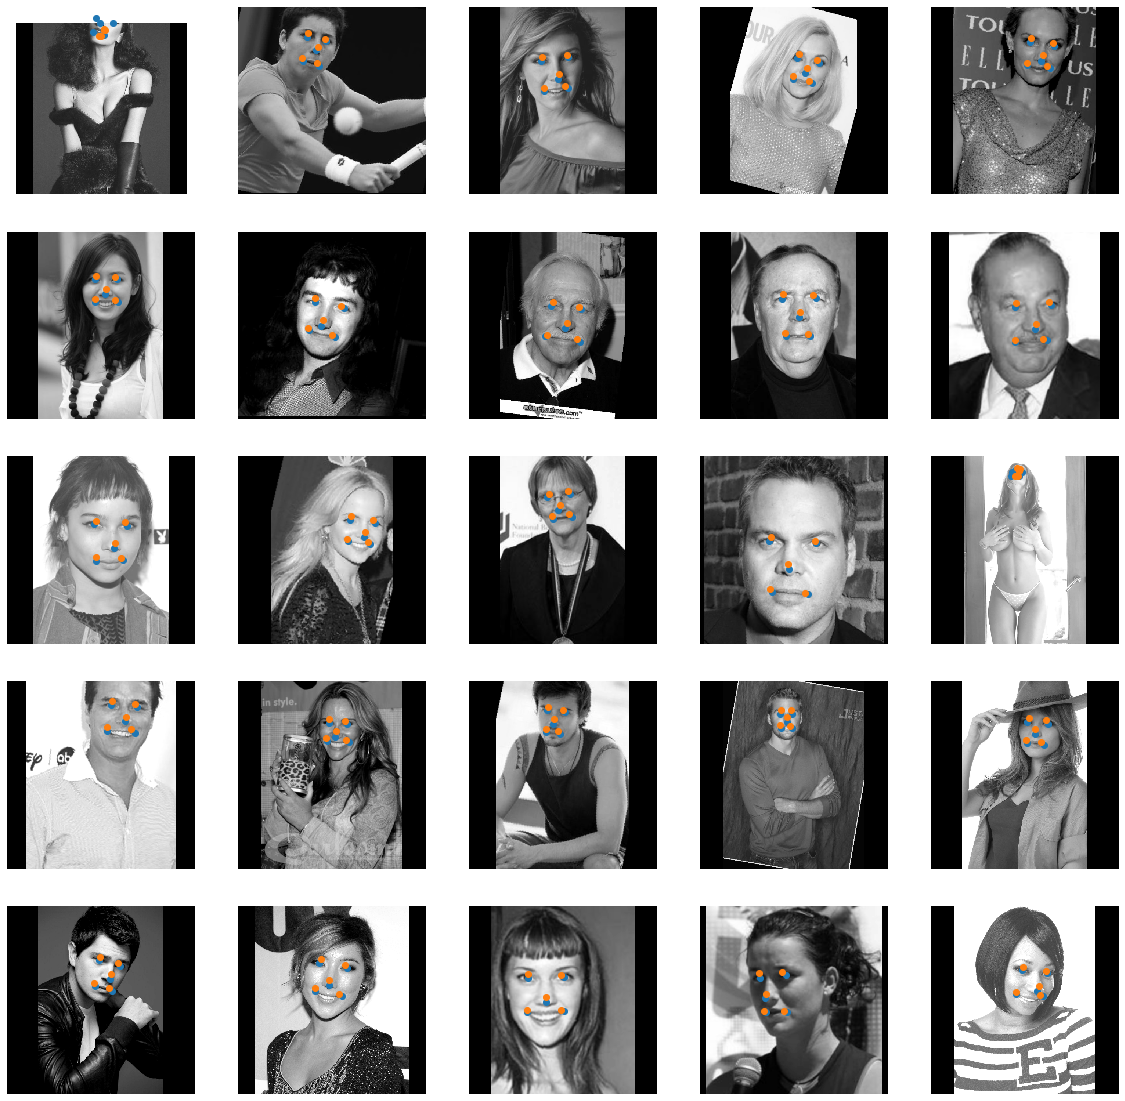

In [103]:
for a,b in faces_val.skip(50).take(1):
    h = model.predict(a)
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8]],np.array(b[n])[[1,3,5,7,9]])
        plt.scatter(np.array(h[n])[[0,2,4,6,8]],np.array(h[n])[[1,3,5,7,9]])
        plt.axis('off')

In [ ]:
# model.save_weights("weights/FACE_LANDMARK_medium_model_epoch_30")

In [ ]:
from PIL import Image
import requests
from io import BytesIO

# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTQhnHuvcWzyFD2TNCCC3kFKkf86T9IEObJ6QzAfn2Ahr93UtRw"

# response = requests.get(url)
# im = Image.open(BytesIO(response.content)).convert('L')
im = Image.open("/mnt/iusers01/jw01/mdefscs4/Capture.PNG").convert('L')
im = im.resize((512,512))

In [ ]:
plt.imshow(np.array(im).reshape((512,512,1))[:, :,0],cmap="gray")

In [ ]:
h = model.predict(np.array(im).reshape((1,512,512,1))/255.0)
plt.imshow(np.array(im).reshape((512,512,1))[:, :,0],cmap="gray")
plt.scatter(np.array(h[0])[[0,2,4,6,8]],np.array(h[0])[[1,3,5,7,9]])

# MAKE FEET WORK

In [ ]:
joints_model = landmarks_model.landmarks_model_feet(test_config,"weights/FACE_LANDMARK_medium_model_epoch_30")

In [ ]:
joints_model.summary()

In [ ]:
from dataset.landmarks_dataset import landmarks_dataset as ld

landmark_dataset = ld(test_config).create_landmarks_dataset()


In [6]:
#joints_model.load_weights("weights/TEST_FEET_LANDMARKS_WEIGHTS_EPOCH_DONTKNOW")

In [ ]:
H = joints_model.fit(landmark_dataset, steps_per_epoch=20,
    epochs=100)

In [ ]:
joints_model.save_weights("weights/TEST_FEET_LANDMARKS_WEIGHTS_MEDIUM_EPOCH_100")

In [ ]:
for a,b in landmark_dataset.take(1):
    h = joints_model.predict(a)
    plt.figure(figsize=(20,20))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8,10]],np.array(b[n])[[1,3,5,7,9,11]])
        plt.scatter(np.array(h[n])[[0,2,4,6,8,10]],np.array(h[n])[[1,3,5,7,9,11]])
        plt.axis('off')

In [ ]:
from PIL import Image, ImageOps


desired_size = 512
im = Image.open("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/UAB472-LF.jpg").convert('L')
old_size = im.size  # old_size[0] is in (width, height) format

ratio = float(desired_size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])
im = im.resize(new_size, Image.ANTIALIAS)
# create a new image and paste the resized on it

new_im = Image.new("L", (desired_size, desired_size))
new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))

im = new_im

In [ ]:
h = joints_model.predict(np.array(im).reshape((1,512,512,1))/255.0)
plt.imshow(np.array(im).reshape((512,512,1))[:, :,0],cmap="gray")
plt.scatter(np.array(h[0])[[0,2,4,6,8,10]],np.array(h[0])[[1,3,5,7,9,11]])

In [ ]:
from PIL import Image, ImageOps
images = ["UAB651-LF.jpg",
"UAB653-LF.jpg",
"UAB654-LF.jpg",
"UAB659-LF.jpg",
"UAB661-LF.jpg",
"UAB665-LF.jpg",
"UAB666-LF.jpg",
"UAB667-LF.jpg",
"UAB669-LF.jpg",
"UAB671-LF.jpg",
"UAB672-LF.jpg",
"UAB675-LF.jpg",
"UAB678-LF.jpg",
"UAB679-LF.jpg",
"UAB680-LF.jpg",
"UAB683-LF.jpg",
"UAB687-LF.jpg",
"UAB688-LF.jpg",
"UAB690-LF.jpg",
"UAB692-LF.jpg",
"UAB694-LF.jpg",
"UAB697-LF.jpg",
"UAB698-LF.jpg",
"UAB700-LF.jpg",
"UAB701-LF.jpg",
"UAB702-LF.jpg",
"UAB703-LF.jpg",
"UAB704-LF.jpg",
"UAB706-LF.jpg",
"UAB707-LF.jpg",
"UAB708-LF.jpg",
"UAB711-LF.jpg",
"UAB716-LF.jpg",
"UAB717-LF.jpg",
"UAB719-LF.jpg",
"UAB720-LF.jpg",
"UAB722-LF.jpg",
]
desired_size = 512
for i in images:
    im = Image.open("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/" + i).convert('L')
    old_size = im.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("L", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    im = new_im
    h = joints_model.predict(np.array(im).reshape((1,512,512,1))/255.0)
    plt.figure(figsize=(5,5))
    plt.imshow(np.array(im).reshape((512,512,1))[:, :,0],cmap="gray")
    plt.scatter(np.array(h[0])[[0,2,4,6,8,10]],np.array(h[0])[[1,3,5,7,9,11]])

# none of the crap down here works

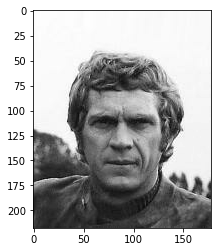

In [51]:
plt.imshow(np.array(a[n])[:, :,0],cmap="gray")

In [46]:
mobile_net = keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None)

In [47]:
new_model = keras.models.Sequential()
new_model.add(mobile_net)

In [48]:
new_model.add(keras.layers.MaxPooling2D((2,2)))
new_model.add(keras.layers.Flatten())
new_model.add(keras.layers.Dense(50, activation='relu'))
new_model.add(keras.layers.Dense(10, activation='linear'))

In [49]:
for layer in new_model.layers[:-2]:
    layer.trainable = False
new_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [50]:
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                576050    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
Total params: 2,834,544
Trainable params: 576,560
Non-trainable params: 2,257,984
_________________________________________________________________


In [51]:
def resize_image(img,y):
    img = tf.image.resize_with_pad(img, 224, 224)
    img=tf.stack([img, img, img], axis=-1)
    img=tf.reshape(img, shape=(25,224,224,3))
    return img,y
dataset = dataset.map(resize_image)
dataset_val = dataset_val.map(resize_image)

In [54]:
H = new_model.fit(dataset, validation_data=dataset_val,
    epochs=30,validation_steps=10)

Epoch 1/30
   1983/Unknown - 49s 25ms/step - loss: 65.5014 - mae: 6.2884

KeyboardInterrupt: 

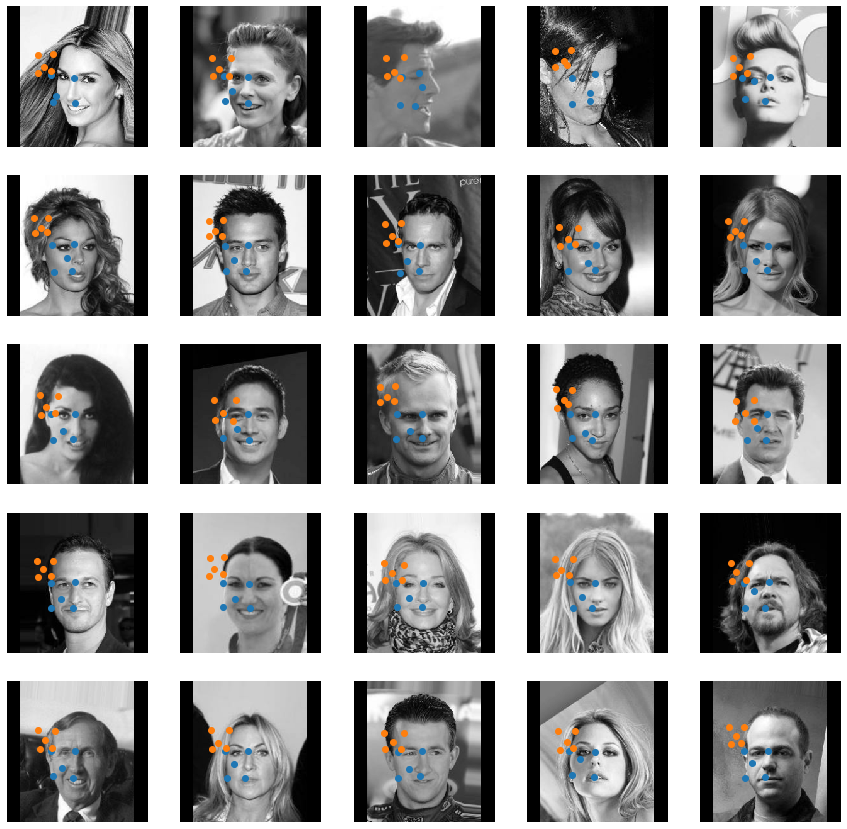

In [55]:
for a,b in dataset_val.take(1):
    h = new_model.predict(a)
    plt.figure(figsize=(15,15))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(np.array(a[n])[:, :,0],cmap="gray")
        plt.scatter(np.array(b[n])[[0,2,4,6,8]],np.array(b[n])[[1,3,5,7,9]])
        plt.scatter(np.array(h[n])[[0,2,4,6,8]],np.array(h[n])[[1,3,5,7,9]])
        plt.axis('off')